### Задание для курсового проекта

Метрика:
rmse -корень среднеквадратичного отклонения

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data


**Построение модели регресси**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Загружаем библиотеки

In [548]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.image as img
from scipy import stats

In [549]:
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [550]:
import warnings
warnings.filterwarnings('ignore')

In [551]:
matplotlib.rcParams.update({'font.size': 14})

In [552]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [553]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Загрузка данных
**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [554]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [555]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [556]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [557]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [558]:
test_df.shape

(5000, 19)

## EDA
### 1) Приводим типы данных

In [559]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [560]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [561]:
train_df.shape

(10000, 20)

In [562]:
test_df.shape

(5000, 19)

In [563]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### 2) Визуализируем данные, проверяем данные на логичность и наличие пропусков на основе describe и info, например: площадь не должна быть равна 0, кол-во этажей не может быть 0 и пр.

### Смотрим распределение целевой переменной
Наблюдение: большинство значений целевой переменной смещено влево, что означает что среднее лучше не брать для заполнения пропусков.

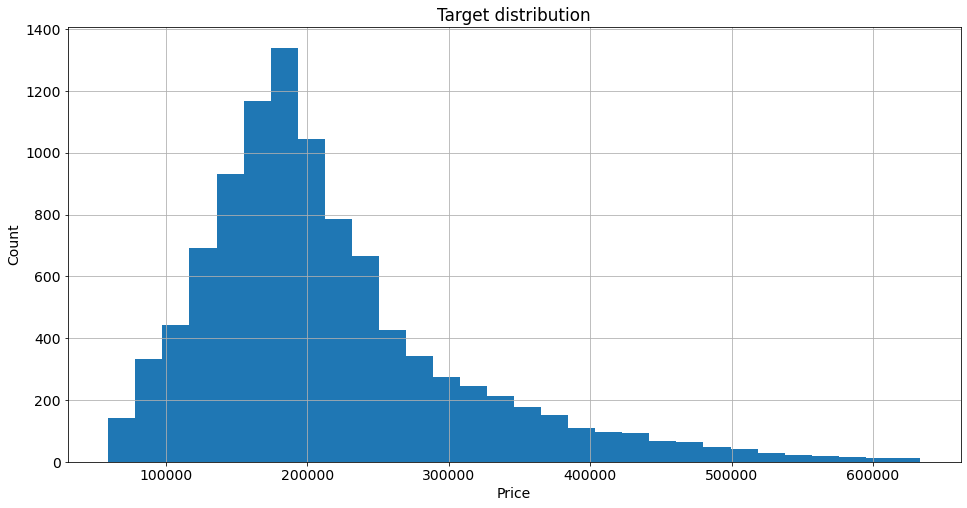

In [564]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins = 30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [565]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [566]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

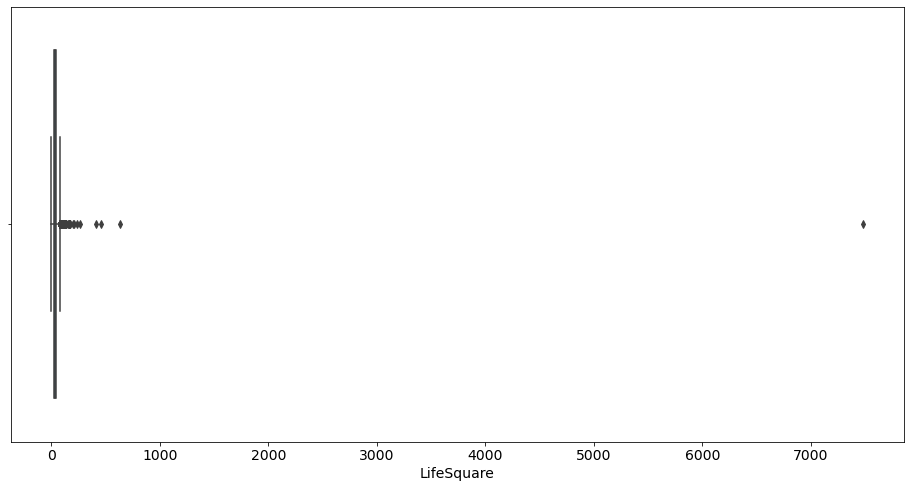

In [567]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

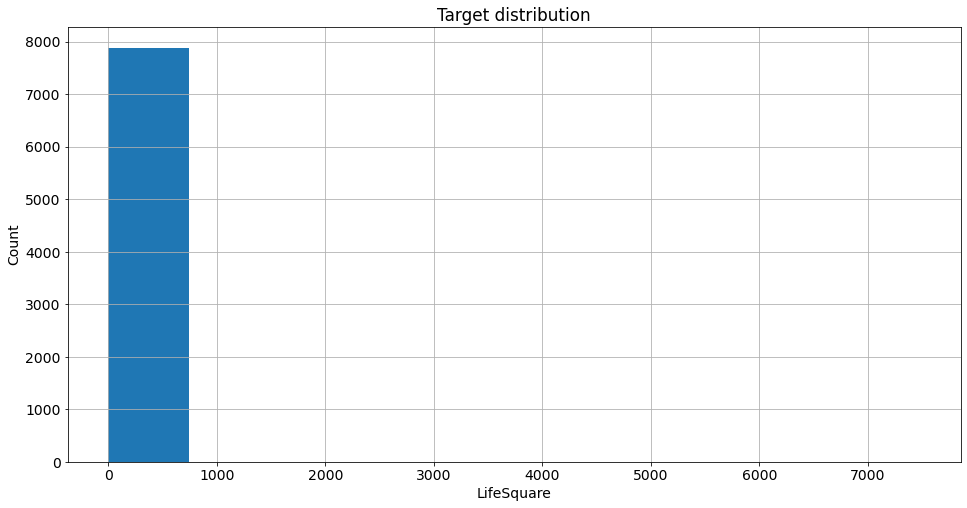

In [568]:
plt.figure(figsize=(16, 8))
train_df['LifeSquare'].hist(bins = 10)
plt.ylabel('Count')
plt.xlabel('LifeSquare')

plt.title('Target distribution')
plt.show()

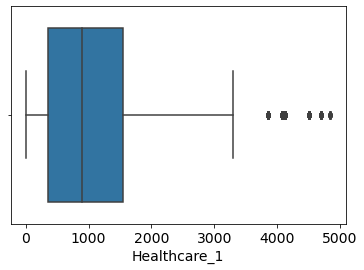

In [569]:
sns.boxplot(train_df['Healthcare_1'], whis=1.5)

Наблюдение: 1) Есть пропущенные значения в признаках LifeSquare, Helthcare_1, 2) значения признаков имеют разный масштаб, 3) Есть странные значения в полях: HouseFloor - 0, Square и LifeSquare - 1.13 и 0.37, Rooms - 0; LifeSqure и KitchenSquare в некоторых случаях больше, чем Square; в некоторых случаях оч большое кол-во комнат - 19

### Посмотрим значения качественных переменных

In [570]:
train_df.select_dtypes(include='category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

Альтерантивная функция поиска категориальных переменных или переменных, где есть ограниченное кол-во значений (<=3)

In [571]:
#def find_cat(data):
#    for name in data.columns:
#        s = ''
#        s += name
#        if (type(data[name]) == str):
#           s += ' string,'
#        if (data[name].nunique()<=3):
#            s += ' few unique values'
#        if (s!=name):
#            print(s)

In [572]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [573]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [574]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Посмотрим, как отличается распределение целевой переменной и ее медиана в зависимости от значения категориального признака

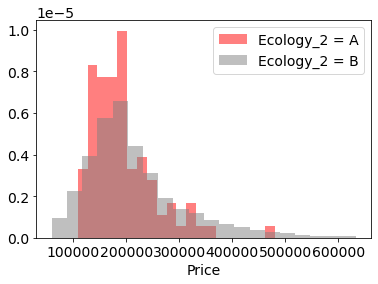

In [575]:
plt.hist(train_df.loc[train_df['Ecology_2']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Ecology_2 = A')
plt.hist(train_df.loc[train_df['Ecology_2']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Ecology_2 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [576]:
train_df_cat = train_df.groupby('Ecology_2').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)

train_df_cat

,Price
Ecology_2,
A,182516.562500
B,192371.640625


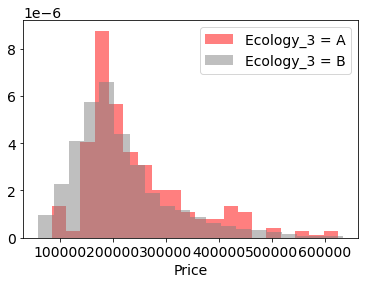

In [577]:
plt.hist(train_df.loc[train_df['Ecology_3']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Ecology_3 = A')
plt.hist(train_df.loc[train_df['Ecology_3']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Ecology_3 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [578]:
train_df_cat = train_df.groupby('Ecology_3').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)
train_df_cat

,Price
Ecology_3,
A,211889.93750
B,191668.40625


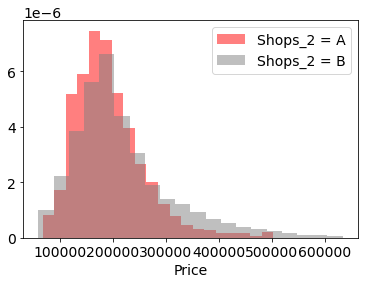

In [579]:
plt.hist(train_df.loc[train_df['Shops_2']=='A','Price'], bins=20, density=True, color='Red', alpha=0.5, label='Shops_2 = A')
plt.hist(train_df.loc[train_df['Shops_2']=='B','Price'], bins=20, density=True, color='Gray', alpha=0.5, label='Shops_2 = B')
plt.xlabel('Price')
plt.legend(loc='upper right')
plt.show()

In [580]:
train_df_cat = train_df.groupby('Shops_2').median()['Price']
type(train_df_cat)
train_df_cat = pd.DataFrame(train_df_cat)
train_df_cat

,Price
Shops_2,
A,181620.000
B,193446.125


### 3) Обработка данных на основе наблюдений (пропуски, выбросы, чистка ошибочных значений, удаление очевидно лишних признаков

In [581]:
train_df = train_df.drop('Id', axis =1 )

In [582]:
test_df = test_df.drop('Id', axis =1)

In [583]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

In [584]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [585]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Заполняем пропуски и экстремальные значения кол-ва комнат

In [586]:
class Preproc:
    def fit_emiss(self, data):
        self.emiss_median_Rooms = data['Rooms'].median()
        self.emiss_median_LifeSquare = data['LifeSquare'].median()
        self.emiss_median_Healthcare_1 = data['Healthcare_1'].median()
        self.emiss_median_HouseFloor = data['HouseFloor'].median()
        
        #self.emiss_floor_out = data.loc[data['Floor'] > data['HouseFloor']].index        
        #floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index 
    def transf_emiss(self, data):
        #Пропуски
        data.loc[(data['Rooms'] > 6) | (data['Rooms'] == 0), 'Rooms'] = self.emiss_median_Rooms
        data.loc[data['HouseFloor']==0, 'HouseFloor'] = self.emiss_median_HouseFloor
        #Выбросы
        data['LifeSquare'] = data['LifeSquare'].fillna(self.emiss_median_LifeSquare)
        data['Healthcare_1'] = data['Healthcare_1'].fillna(self.emiss_median_Healthcare_1)
        #Обработки категориальных переменных
        data = pd.concat([data, pd.get_dummies(data['Ecology_2'])], axis=1)
        data = data.rename(columns={'A':'Ecology_2_A', 'B':'Ecology_2_B'})
        data = pd.concat([data, pd.get_dummies(data['Ecology_3'])], axis=1)
        data = data.rename(columns={'A':'Ecology_3_A', 'B':'Ecology_3_B'})
        data = pd.concat([data, pd.get_dummies(data['Shops_2'])], axis=1)
        data = data.rename(columns={'A':'Shops_2_A', 'B':'Shops_2_B'})
        return data
    
    

prep = Preproc()
prep.fit_emiss(train_df)
train_df = prep.transf_emiss(train_df)
test_df = prep.transf_emiss(test_df)

In [587]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,B,...,0,0,B,305018.875000,0,1,0,1,0,1
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,1,0,B,177734.546875,0,1,0,1,0,1
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,3,1,B,282078.718750,0,1,0,1,0,1
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,B,...,0,1,B,168106.000000,0,1,0,1,0,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,0,6,B,343995.093750,0,1,0,1,0,1


In [588]:
train_df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

In [589]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     5000 non-null   int16   
 1   Rooms          5000 non-null   float32 
 2   Square         5000 non-null   float32 
 3   LifeSquare     5000 non-null   float32 
 4   KitchenSquare  5000 non-null   float32 
 5   Floor          5000 non-null   int8    
 6   HouseFloor     5000 non-null   float32 
 7   HouseYear      5000 non-null   int16   
 8   Ecology_1      5000 non-null   float32 
 9   Ecology_2      5000 non-null   category
 10  Ecology_3      5000 non-null   category
 11  Social_1       5000 non-null   int8    
 12  Social_2       5000 non-null   int16   
 13  Social_3       5000 non-null   int16   
 14  Healthcare_1   5000 non-null   float32 
 15  Helthcare_2    5000 non-null   int8    
 16  Shops_1        5000 non-null   int8    
 17  Shops_2        5000 non-null   ca

In [590]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888800,56.315720,36.266029,6.273300,8.526700,12.959100,3.990166e+03,0.118858,24.687000,...,1026.358887,1.319500,4.231300,214138.937500,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.812107,21.058716,76.609962,28.560839,5.241148,6.443573,2.005003e+05,0.119025,17.532614,...,746.644226,1.493601,4.806341,92872.273438,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,25.527400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,...,830.000000,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,...,900.000000,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,65.900627,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,...,990.000000,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,6.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Убираем случаи, когда этаж больше, чем кол-во этажей в доме

In [591]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

In [592]:
train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [593]:
floor_out_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

In [594]:
test_df.loc[floor_out_test, 'Floor'] = test_df.loc[floor_out_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Убираем выбросы в данных Square, KitchenSquare, LifeSquare

In [595]:
train_df.loc[(train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) |
        (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.025)), 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[(train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975)) |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025)), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[(train_df['Square'] > train_df['Square'].quantile(.975)) |
                   (train_df['Square'] < train_df['Square'].quantile(.025)), 'Square'] = train_df['Square'].median()

In [596]:
test_df.loc[(test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.975)) |
        (test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.025)), 'KitchenSquare'] = test_df['KitchenSquare'].median()
test_df.loc[(test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.975)) |
                    (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.025)), 'LifeSquare'] = test_df['LifeSquare'].median()
test_df.loc[(test_df['Square'] > test_df['Square'].quantile(.975)) |
                   (test_df['Square'] < test_df['Square'].quantile(.025)), 'Square'] = test_df['Square'].median()

Находим случаи, когда жилая площадь/ площадь кухни больше, чем общая площадь и заменяем их нормальными значениями (экспертно оцениваем, что нормальные значения для площади кухни - 1/5 от общей площади, для жилой площади -  2/3 от общей площади)

In [597]:
train_df.loc[train_df['KitchenSquare'] > train_df['Square'], 'KitchenSquare'] = train_df['Square']/5
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square']/1.5

In [598]:
test_df.loc[test_df['KitchenSquare'] > test_df['Square'], 'KitchenSquare'] = test_df['Square']/5
test_df.loc[test_df['LifeSquare'] > test_df['Square'], 'LifeSquare'] = test_df['Square']/1.5

Убираем нулевые значения и площади кухни и приравниваем к 3 (экспертно)

In [599]:
train_df.loc[train_df['KitchenSquare']<3, 'KitchenSquare'] = 3

In [600]:
test_df.loc[test_df['KitchenSquare']<3, 'KitchenSquare'] = 3

In [601]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888800,55.108181,33.606762,6.238200,7.400100,12.959100,3.990166e+03,0.118858,24.687000,...,1026.358887,1.319500,4.231300,214138.937500,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,43.587592,0.812107,15.215080,10.393131,2.794661,5.051947,6.443573,2.005003e+05,0.119025,17.532614,...,746.644226,1.493601,4.806341,92872.273438,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.000000,1.000000,32.105270,15.146290,3.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,42.432730,27.184790,3.000000,3.000000,9.000000,1.974000e+03,0.017647,6.000000,...,830.000000,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,6.000000,13.000000,1.977000e+03,0.075424,25.000000,...,900.000000,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,75.000000,2.000000,64.591721,36.936258,8.000000,11.000000,17.000000,2.001000e+03,0.195781,36.000000,...,990.000000,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,209.000000,6.000000,100.904266,78.384628,13.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,...,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [602]:
test_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,51.279200,1.907800,55.450382,33.702961,6.208400,7.550400,12.941600,1984.392600,0.119874,24.933800,...,8.262600,1029.396362,1.31940,4.242800,0.009600,0.990400,0.029800,0.970200,0.082400,0.917600
std,44.179466,0.810094,15.286419,10.238296,2.727032,5.169333,6.466835,18.573149,0.120070,17.532202,...,23.863762,766.589233,1.47994,4.777365,0.097518,0.097518,0.170052,0.170052,0.275001,0.275001
min,0.000000,1.000000,32.113449,14.525565,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.000000,42.703357,27.499318,3.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,...,0.000000,810.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,37.000000,2.000000,52.921341,32.781261,6.000000,6.000000,13.000000,1977.000000,0.072158,25.000000,...,2.000000,900.000000,1.00000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,77.000000,2.000000,65.215668,37.297899,8.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,...,5.000000,990.000000,2.00000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,212.000000,6.000000,100.729996,77.408134,12.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,...,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [603]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int64   
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   10000 non-null  float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

### Строим модель

In [604]:
#feat = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']
x = train_df.drop(['Price', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
#x.head()
#x = train_df[feat]
y = train_df['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

In [605]:
x_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9185,56,2.0,78.364532,36.151920,6.0,15,20.0,2018,0.000000,23,...,4,900.0,2,6,0,1,0,1,0,1
6945,8,2.0,47.699688,31.891401,5.0,8,9.0,1969,0.458174,26,...,1,1130.0,1,5,0,1,1,0,0,1
6615,47,2.0,55.038437,33.244614,8.0,2,12.0,1978,0.000070,46,...,1,240.0,1,16,0,1,0,1,0,1
9527,11,2.0,46.404854,31.859941,6.0,5,9.0,1977,0.038693,28,...,1,1015.0,2,5,0,1,0,1,0,1
4336,27,1.0,37.814663,25.209776,10.0,20,22.0,2019,0.211401,9,...,0,900.0,0,1,0,1,0,1,0,1


In [606]:
y_train.shape

(7000,)

In [607]:
forest = RandomForestRegressor()

In [608]:
forest.fit(x_train, y_train)

RandomForestRegressor()

Train R2:	0.9573
Test R2:	0.744


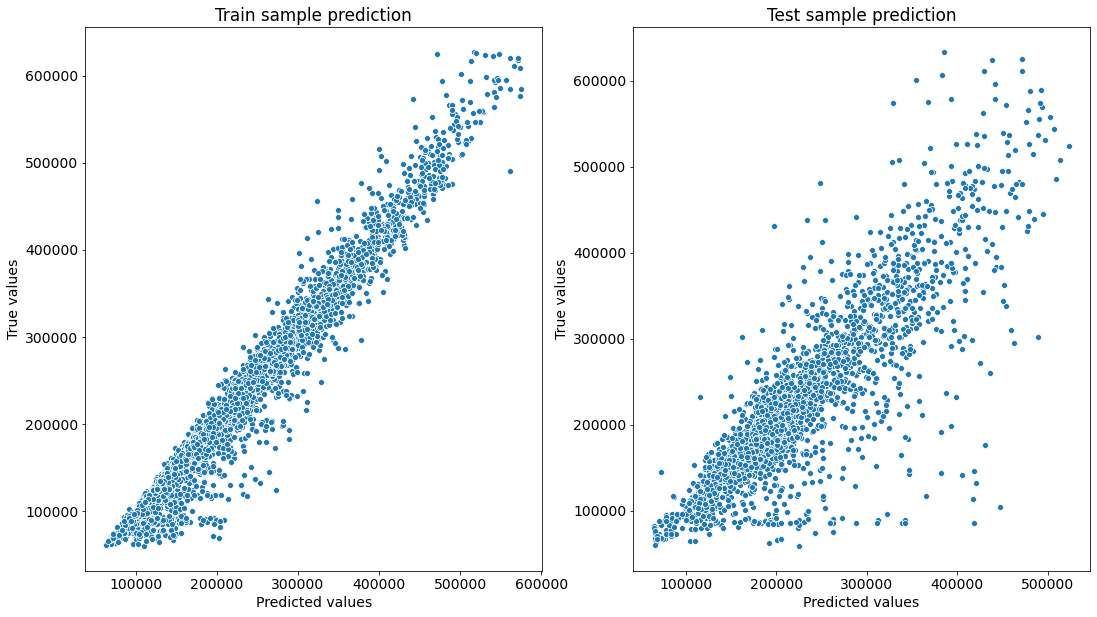

In [609]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [610]:
r2(y_train, train_pred )

0.9572699440877626

In [611]:
r2(y_test, test_pred)

0.7440304200408104

In [612]:
x_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9185,56,2.0,78.364532,36.151920,6.0,15,20.0,2018,0.000000,23,...,4,900.0,2,6,0,1,0,1,0,1
6945,8,2.0,47.699688,31.891401,5.0,8,9.0,1969,0.458174,26,...,1,1130.0,1,5,0,1,1,0,0,1
6615,47,2.0,55.038437,33.244614,8.0,2,12.0,1978,0.000070,46,...,1,240.0,1,16,0,1,0,1,0,1
9527,11,2.0,46.404854,31.859941,6.0,5,9.0,1977,0.038693,28,...,1,1015.0,2,5,0,1,0,1,0,1
4336,27,1.0,37.814663,25.209776,10.0,20,22.0,2019,0.211401,9,...,0,900.0,0,1,0,1,0,1,0,1


## Используем GridSearch для поиска наиболее подходящих параметров

In [613]:
%%time
estimator=RandomForestRegressor(random_state=100)

Wall time: 0 ns


In [614]:
parameters = [{'n_estimators': [60, 130], 'max_features': np.arange(2, 7), 'max_depth': np.arange(4, 40)}]

In [615]:
gs = GridSearchCV(estimator, param_grid=parameters, scoring='r2', cv=5 )

In [616]:
#%%time
#gs.fit(x_train, y_train)

In [617]:
#gs.best_params_

In [618]:
final_model = RandomForestRegressor(n_estimators=100, max_features=4, max_depth=22, random_state=100)

In [619]:
%%time
final_model.fit(x_train, y_train)

Wall time: 2.3 s


RandomForestRegressor(max_depth=22, max_features=4, random_state=100)

Train R2:	0.9574
Test R2:	0.7535


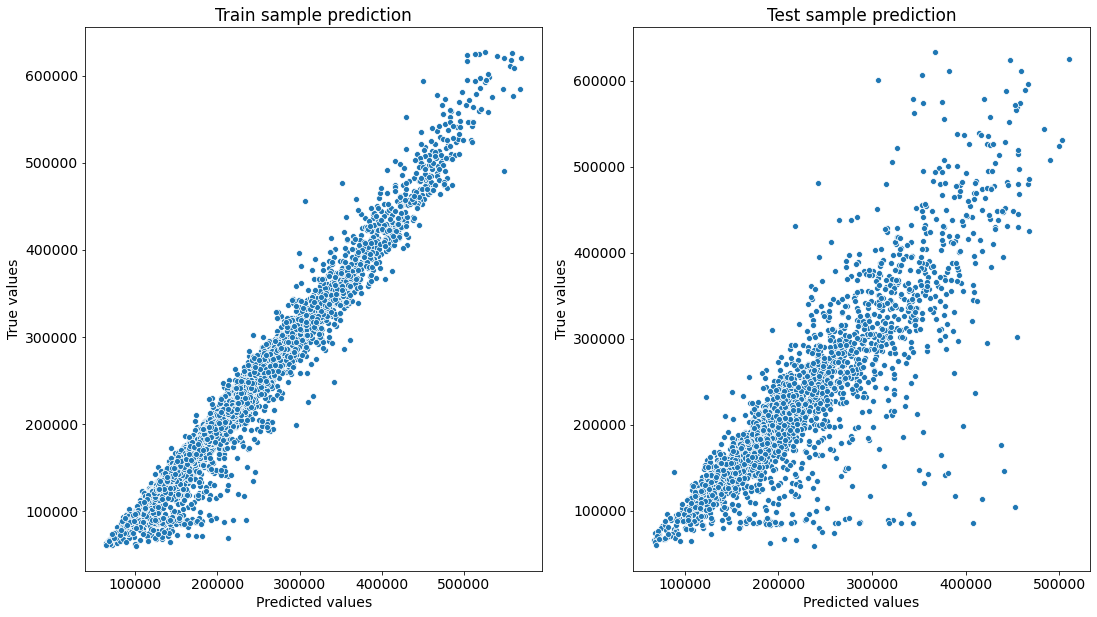

In [620]:
train_pred_final = final_model.predict(x_train)
test_pred_final = final_model.predict(x_test)
evaluate_preds(y_train, train_pred_final, y_test, test_pred_final)

Попробовал использовать линейную регрессию - она справилась знаительно хуже (даже со стандртизацией и понижением размерности). R2 был около 0,5

## Итоговое предсказание

In [621]:
final_model.fit(x, y)

RandomForestRegressor(max_depth=22, max_features=4, random_state=100)

In [622]:
itog_test = test_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)

In [623]:
itog_test.shape

(5000, 21)

In [624]:
pred = pd.DataFrame(final_model.predict(itog_test), columns=['pred'])
pred.head()

,pred
0,158042.677588
1,114214.332360
2,142498.125778
3,151553.630781
4,205482.541477


In [626]:
pred.to_csv('Posadskov_predict.csv', index=False)